# The Catalog Object


## Learning Objectives

In this tutorial, you will learn:

- the purpose and scope of the `Catalog` object in an LSDB pipeline
- What are lazy operations and how LSDB uses them to run pipelines at any scale.

## Introduction

The `Catalog` object encapsulates all of the information that LSDB knows about an astronomical catalog, and is the basis for performing operations on the underlying catalog data.

There are two types of catalog data that the `Catalog` object exposes:
1. high-level metadata: The columns and table schema of the catalog, the number of partitions of data, sky coverage, provenance information, basic aggregate statistics about the data.
1. leaf-level tabular data: the full rows of data from the objects and/or observations in the catalog.


## 1. Loading a catalog

The simplest way to load a catalog in LSDB is to call `lsdb.open_catalog()` with a path to a catalog in the HATS format. This will return a `Catalog` object with all the high level metadata loaded that LSDB needs to enable you to work with the catalog. We recommend you to visit our own website, [data.lsdb.io](https://data.lsdb.io), where you are able to find large surveys in HATS format publicly available to use. Let's open GAIA DR3 as an example and take a look at the object we get back.

In [2]:
import lsdb

In [3]:
gaia_path = "https://data.lsdb.io/hats/gaia_dr3"
gaia = lsdb.open_catalog(gaia_path)
gaia

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
npartitions=2016,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 2, Pixel: 0",int64[pyarrow],string[pyarrow],int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],bool[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int16[pyarrow],int16[pyarrow],float[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],int8[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],bool[pyarrow],int16[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int16[pyar

### Lazy operations

When we look at the catalog's representation above, we can see all the columns that are in the catalog object along with their datatypes, and information about how HATS has partitioned the catalog. But there's one thing that we can't see: we haven't loaded any of the data yet! That's why we have the `...` as placeholders for the data, and the warning at the bottom. This is because LSDB's operations are what we call *lazy*: they don't actually perform any work on the data when you call them, they just plan out the pipeline of operations to be performed later. This is how LSDB can work on huge catalogs with billions of rows, and run on any scale of device from a laptop up to a supercomputer.

<video src="../_static/lazy-flowchart.mp4" loop autoplay controls></video>

As explained in the video above, when you call any LSDB operations on the catalog, a task graph is built up - an object that keeps track of the pipeline of operations you want to perform on the catalog. To actually execute the operations, you call the `catalog.compute()` method, which will execute the pipeline and return the resulting data as a pandas `DataFrame`.

## 2. Inspecting the Catalog metadata

The natural next step once you have a catalog object is to explore the metadata that has been loaded to understand what kind of data is inside your catalog.

First, we will generate a basic plot showing the sky coverage of the catalog. The `Catalog` object's `plot_pixels` method shows a plot of the HATS partitioning of the catalog. GAIA is a survey that covers the whole sky, so we see the whole sky covered in pixels. The colors of the pixels represent the pixel sizes. The main advantage of HATS partitioning is that the partitions all contain roughly the same amount of rows, so the smaller the pixels, the more dense the catalog is in that area. This explains why we see smaller pixels in the galactic bulge.

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel map - gaia'}>)

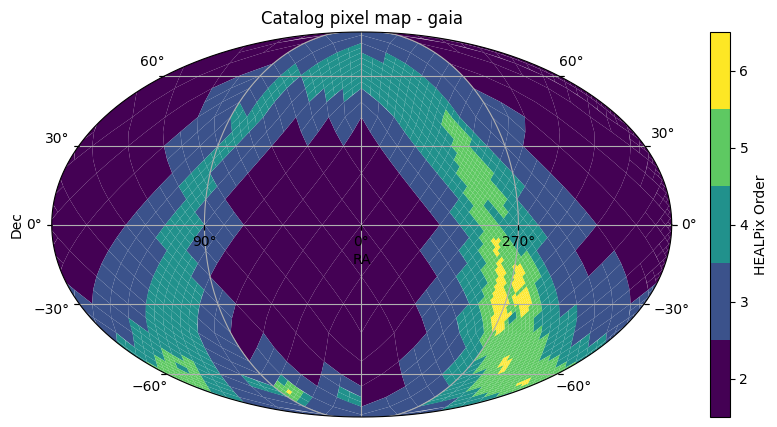

In [4]:
gaia.plot_pixels()

We can also get an idea of the schema of data that's stored in the catalog, by looking at the `columns` and `dtypes`.

In [5]:
gaia.columns

Index(['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       ...
       'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper',
       'ag_gspphot', 'ag_gspphot_lower', 'ag_gspphot_upper',
       'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper',
       'libname_gspphot'],
      dtype='object', length=152)

In [6]:
gaia.dtypes

solution_id                int64[pyarrow]
designation               string[pyarrow]
                               ...       
ebpminrp_gspphot_upper     float[pyarrow]
libname_gspphot           string[pyarrow]
Length: 152, dtype: object

In [7]:
len(gaia)

1812731847

We can also see how many objects are in the catalog, which is another piece of metadata that is loaded by `open_catalog`.

## 3. Operating on the Catalog

Once we have a catalog object, we can start planning operations on it. In the rest of the tutorials, we'll look deeper into exactly what kind of operations you can do with a catalog. The catalog is based on pandas `DataFrames` so you'll see some functions that work the same as in pandas, such as `columns`, `dtypes`, `query`, and selecting columns or filtering with `[]`.

After you've performed your operations, you can call `catalog.compute()` to perform the pipeline, but this will run on the entire catalog!

## 4. Previewing part of the data

Computing an entire catalog will result in loading all of its data into memory on your local machine after the workers have computed it, which is expensive and may lead to out-of-memory issues.

Often, our goal is to have a peek at a slice of data to make sure the workflow output is reasonable (e.g., to assess if some new created columns are present and their values have been properly processed). `head()` is a pandas-like method which allows us to preview part of the data for this purpose. It runs the pipeline on the catalog partitions one by one, and finds the first few rows of the results.

### Making a Dask client

LSDB is built on top of the [Dask](https://www.dask.org) framework, which allows the pipelines to be executed on distributed workers. Before we do anything that executes the pipeline such as `head()` or `compute()`, we recommend making a dask client.

In [8]:
from dask.distributed import Client

client = Client(n_workers=4, memory_limit="auto")
client

/Users/smcmu/.pyenv/versions/3.11.10/envs/lsdb/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60472 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:60472/status,
Dashboard: http://127.0.0.1:60472/status,Workers: 4
Total threads: 12,Total memory: 19.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60473,Workers: 4
Dashboard: http://127.0.0.1:60472/status,Total threads: 12
Started: Just now,Total memory: 19.20 GiB
Comm: tcp://127.0.0.1:60484,Total threads: 3
Dashboard: http://127.0.0.1:60489/status,Memory: 4.80 GiB
Nanny: tcp://127.0.0.1:60476,


In [ ]:
gaia.head()

By default, the first 5 rows of data will be shown, but we can specify a higher number if we need.

In [ ]:
gaia.head(n=10)

### Closing the Dask client

In [ ]:
client.close()

## About

**Authors**: Sandro Campos, Melissa DeLucchi, and Sean McGuire

**Last updated on**: Jun 26, 2025

If you use `lsdb` for published research, please cite following [instructions](https://docs.lsdb.io/en/stable/citation.html).